## Code generation

In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install sympy
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib

In [2]:
# Remove matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# initialize sympy printing (for latex output)
from sympy import init_printing, Symbol
init_printing()

# import functions and classes for compartment models
import sys
sys.path.insert(0, "./compartor") #use local copy
from compartor import *

Here, we illustrate how to export the moment equations in LaTeX format or generate code for simulations.

We consider again the exemplary model of the paper and derive moments equations with the automated function.

In [15]:
x = Content('x')
y = Content('y')
z = Content('z')

from sympy import log, symbols
kM = symbols('kM') # The Michaelis-Menten constant

# define intake distribution
pi_I = OutcomeDistribution.Poisson(Symbol("\pi_{Poiss}(y; \lambda)"), y[0], Symbol("\lambda"))
# define fragmentation distribution
pi_F = OutcomeDistribution.Uniform(Symbol("\pi_F(y|x)"), y[0], 0, x[0])

Intake        = TransitionClass( {}        -to> [y],         'k_I',         pi=pi_I, name='I')
Exit          = TransitionClass( [x]       -to> {},          'k_E',                  name='E')
Coagulation   = TransitionClass( [x] + [y] -to> [x+y],       'k_C',                  name='C')
# Coagulation   = TransitionClass( [x] + [y] -to> [x+y],       'k_C', g=log(x[0])*log(y[0]),     name='C')
Fragmentation = TransitionClass( [x]       -to> [y] + [x-y], 'k_F', g=x[0], pi=pi_F, name='F')
Birth         = TransitionClass( [x]       -to> [x+1],       'k_b',                  name='b')
# Death         = TransitionClass( [x]       -to> [x-2],       'k_d', g=x[0],    name='d')
Death         = TransitionClass( [x]       -to> [x-2],       'k_d', g=x[0]*(x[0]-1)/2,    name='d')
# Death         = TransitionClass( [x]       -to> [x-2],       'k_d', g=x[0]/(x[0]+kM),    name='d')

# transitions = [Intake, Exit, Coagulation, Fragmentation]
transitions = [Intake, Exit, Coagulation, Fragmentation, Birth, Death]
# transitions = [Coagulation, Death]
display_transition_classes(transitions)

                     EmptySet ---> [y],  h_I = \pi_{Poiss}(y; \lambda)*k_I    
                               [x] ---> EmptySet,  h_E = k_E*n(x)             
[x] + [y] ---> [x + y],  h_C = k_C*(n(y) - KroneckerDelta(x, y))*n(x)/(Kroneck
                    [x] ---> [x - y] + [y],  h_F = \pi_F(y|x)*k_F*n(x)*x[0]   
                              [x] ---> [(1,) + x],  h_b = k_b*n(x)            
                    [x] ---> [(-2,) + x],  h_d = k_d*(x[0] - 1)*n(x)*x[0]/2   

                  
                  
erDelta(x, y) + 1)
                  
                  
                  

In [16]:
moments = [
    Moment(0),
    Moment(0)**2,
    Moment(1),
    Moment(1)**2
]
display(moments)
equations = automated_moment_equations(1, transitions, moments, clna=True)
# equations = automated_moment_equations(1, transitions, moments, clna=False)
display_moment_equations(equations)

⎡                 2                      2   ⎤
⎣Moment(0), Moment (0), Moment(1), Moment (1)⎦

Computed moment equations for desired moments $\left< N\right> $, $\left< N^{2}\right> $, $\left< M^{1}\right> $, and $\left< {\left(M^{1}\right)}^{\mathtt{\text{2}}}\right> $.

Equations were iteratively added for $\left< N M^{1}\right> $.

                                      2                                       
d                      k_C⋅Expectation (N)   k_C⋅Expectation(N)               
──(Expectation(N)) = - ─────────────────── + ────────────────── - k_E⋅Expectat
dt                              2                    2                        

                                         
                                         
ion(N) + k_F⋅Expectation(Moment(1)) + k_I
                                         

                                                           2                  
d ⎛           ⎛ 2⎞⎞                  3      k_C⋅Expectation (N)               
──⎝Expectation⎝N ⎠⎠ = k_C⋅Expectation (N) + ─────────────────── - 2⋅k_C⋅Expect
dt                                                   2                        

                                                                              
                    ⎛ 2⎞   k_C⋅Expectation(N)                  ⎛ 2⎞           
ation(N)⋅Expectation⎝N ⎠ - ────────────────── + k_C⋅Expectation⎝N ⎠ + k_E⋅Expe
                                   2                                          

                                                                              
                              ⎛ 2⎞                                            
ctation(N) - 2⋅k_E⋅Expectation⎝N ⎠ + 2⋅k_F⋅Expectation(N⋅Moment(1)) + k_F⋅Expe
                                                                              

                                               
 

                                                                              
d                                                                             
──(Expectation(Moment(1))) = \lambda⋅k_I - k_E⋅Expectation(Moment(1)) + k_b⋅Ex
dt                                                                            

                                                           2           
                                            k_d⋅Expectation (Moment(1))
pectation(N) + k_d⋅Expectation(Moment(1)) - ───────────────────────────
                                                   Expectation(N)      

                                                                              
d ⎛           ⎛      2   ⎞⎞          2                                        
──⎝Expectation⎝Moment (1)⎠⎠ = \lambda ⋅k_I + 2⋅\lambda⋅k_I⋅Expectation(Moment(
dt                                                                            
                                                                              

                                                                   2          
                                     ⎛      2   ⎞   k_E⋅Expectation (Moment(1)
1)) + \lambda⋅k_I - 2⋅k_E⋅Expectation⎝Moment (1)⎠ + ──────────────────────────
                                                           Expectation(N)     
                                                                              

                                                                              
)                                                                             
─ + k_b⋅Expectation(N) + 2⋅k_b⋅Expectation(N⋅Momen

                                                                              
d                                                                         k_C⋅
──(Expectation(N⋅Moment(1))) = \lambda⋅k_I⋅Expectation(N) + \lambda⋅k_I + ────
dt                                                                            
                                                                              

           2                                                                  
Expectation (N)⋅Expectation(Moment(1))                                        
────────────────────────────────────── - k_C⋅Expectation(N)⋅Expectation(N⋅Mome
                2                                                             
                                                                              

                                                                              
         k_C⋅Expectation(N⋅Moment(1))                                         
nt(1)) + ──────────────────────────── - 2⋅k_E⋅Expe

The LaTeX source of the ODE system can be found and copy-pasted by modifying the Math Render option of the jupyter notebook. This is done by right-clicking on the system and choosing Math Settings > Math Render > Plain Source .

From the closed equations, we can also generate code to simulate the system. Currently, Python or Julia code can be generated.

For a direct code output, the user can rely on the functions:

In [13]:
python_code = generate_python_code(equations, function_name="coagulation_fragmentation")
print(python_code)
exec(python_code) 

# evaluate ODEs
def coagulation_fragmentation_ODEs(M, dM, parameters):
  """
  Evaluate derivatives of expected moments
  
  Indices in M and dM vectors are 
    M[0] = Moment(0,)
    M[1] = Moment(0)**2
    M[2] = Moment(1,)
    M[3] = Moment(1)**2
    M[4] = Moment(0)*Moment(1)
  
  :param M: expected moments
  :param dM: result, the derivative dM/dt is stored here
  :param parameters: tuple of values for constants (\lambda, k_C, k_E, k_F, k_I, k_b, k_d)
  :return: dM
  """
  c1 = parameters[0] # \lambda
  c3 = parameters[1] # k_C
  c0 = parameters[2] # k_E
  c5 = parameters[3] # k_F
  c6 = parameters[4] # k_I
  c2 = parameters[5] # k_b
  c4 = parameters[6] # k_d
  # Number of Compartments (N)
  dM[0] = c6+c5*M[2]+1/2*c3*M[0]-c0*M[0]-1/2*c3*M[0]**2
  # N^2
  dM[1] = c6+c3*M[0]**3+c3*M[1]+c0*M[0]+c5*M[2]+1/2*c3*M[0]**2-2*c0*M[1]+2*c5*M[4]+2*c6*M[0]-1/2*c3*M[0]-2*c3*M[1]*M[0]
  # Total Mass
  dM[2] = c1*c6+c2*M[0]-c0*M[2]-2*c4*M[2]
  # M^2
  dM[3] = c1*c6+c6*c1**2+c2*M[0]-4*c4*M[3]-2*c

In [14]:
julia_code = generate_julia_code(equations, function_name="IECFBDq")
print(julia_code)

# evaluate ODEs
function IECFBDq_ODEs(dM, M, parameters, t)
  c0 = ??? # k_E, please specify!
  c1 = ??? # \lambda, please specify!
  c2 = ??? # k_b, please specify!
  c3 = ??? # k_C, please specify!
  c4 = ??? # k_d, please specify!
  c5 = ??? # k_F, please specify!
  c6 = ??? # k_I, please specify!
  # Number of Compartments (N)
  dM[1] = c6+c5*M[3]+1/2*c3*M[1]-c0*M[1]-1/2*c3*M[1]^2
  # N^2
  dM[2] = c6+c3*M[1]^3+c3*M[2]+c0*M[1]+c5*M[3]+1/2*c3*M[1]^2-2*c0*M[2]+2*c5*M[5]+2*c6*M[1]-1/2*c3*M[1]-2*c3*M[2]*M[1]
  # Total Mass
  dM[3] = c1*c6+c2*M[1]-c0*M[3]-2*c4*M[3]
  # M^2
  dM[4] = c1*c6+c6*c1^2+c2*M[1]-4*c4*M[4]-2*c0*M[4]+2*c2*M[5]+4*c4*M[3]+c0*M[3]^2/M[1]+2*c1*c6*M[3]
  # N*M
  dM[5] = c1*c6+c0*M[3]+c5*M[4]+c6*M[3]+c2*M[2]+1/2*c3*M[5]-2*c0*M[5]-2*c4*M[5]+c1*c6*M[1]+1/2*c3*M[1]^2*M[3]-c3*M[5]*M[1]
  return
end

# initialize expected moments vector
function IECFBDq_initial(n0)
  M=zeros[5]
  # Number of Compartments (N)
  M[1] = ??? # initial value for Moment(0,), please specify!
  # N

## Solving and Plotting results
We use the generated functions with `scipy.solve_ivp` to solve the system with the same initial condition and parameter values reported in the paper.

In [8]:
from scipy.integrate import solve_ivp
import numpy as np

# vector of timepoints where to solve ODE problem
timepoints = np.linspace(0, 100, 1000+1)

# initial condition
# 100 compartments with 10 molecules each
N0 = 10
Mpc0=10
M0 = coagulation_fragmentation_initial((N0, N0*Mpc0, (Mpc0**2)*N0,))

# rate constants and other parameters
kC = 0.005
kF = 0.005
kI = 5.0
kE = 0.1
kb = 10.0
kd = 0.1
Lambda = 50
kM = 100
# parameters = (Lambda, kC, kE, kF, kI)
parameters = (Lambda, kC, kE, kF, kI, kb, kd)
# parameters = (Lambda, kM, kC, kE, kF, kI, kb, kd)
# parameters = (kC,kF)

clnaFun = lambda t, M: coagulation_fragmentation_ODEs(M, np.zeros(len(M)), parameters+(M[2]/M[0],))

# solve
sol = solve_ivp(
    clnaFun,
    (np.min(timepoints), np.max(timepoints)),
    M0,
    method='BDF',
    t_eval=timepoints)

# print solution of N
print(sol.y[0])

[10.         10.43030197 10.86442095 ... 38.55367312 38.55367616
 38.5536792 ]


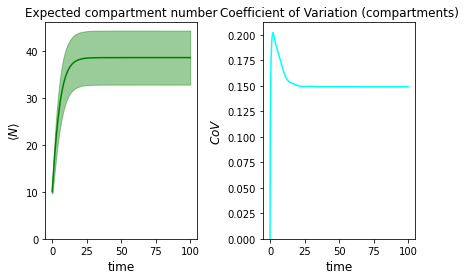

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

y = sol.y
N = y[0]
N2 = y[1]
stdN = np.sqrt(N2 - N**2)

# <N>
plt.subplot(1,2, 1)
plt.plot(timepoints, N, color="g")
plt.ylabel(r'$\left< N \right>$', size=12)
plt.xlabel('time', size=12)
plt.title("Expected compartment number", size=12)
plt.fill_between(timepoints, N-stdN, N+stdN, alpha=0.4, color="g")
# plt.ylim((50,150))
plt.ylim(bottom=0)

# CoV(N)
plt.subplot(1,2, 2)
CoV = stdN / N
plt.plot(timepoints, CoV, color="cyan")
plt.ylabel(r'$CoV$', size=12)
plt.xlabel('time', size=12)
plt.title("Coefficient of Variation (compartments)", size=12)
# plt.ylim((50,150))
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

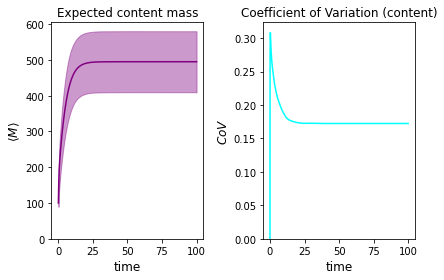

In [10]:
y = sol.y
M = y[2]
M12 = y[3]
stdM = np.sqrt(M12 - M**2)

# <M>
plt.subplot(1,2, 1)
plt.plot(timepoints, M, color="purple")
plt.ylabel(r'$\left< M \right>$', size=12)
plt.xlabel('time', size=12)
plt.title("Expected content mass", size=12)
plt.fill_between(timepoints, M-stdM, M+stdM, alpha=0.4, color="purple")
# plt.ylim((50,150))
plt.ylim(bottom=0)

# CoV(M)
plt.subplot(1,2, 2)
CoV = stdM / M
plt.plot(timepoints, CoV, color="cyan")
plt.ylabel(r'$CoV$', size=12)
plt.xlabel('time', size=12)
plt.title("Coefficient of Variation (content)", size=12)
# plt.ylim((50,150))
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()